# Gender Bias in Word Embeddings 
In this notebook, we aim to re-create results from [Bolukbasi, Tolga, et al. "Man is to computer programmer as woman is to homemaker? Debiasing word embeddings.](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf)" Advances in Neural Information Processing Systems. 2016.

The author's [code](https://github.com/tolga-b/debiaswe) was a great help.

In [1]:
# First, we download a condensed version of word2vec trained on Google News: 
# https://drive.google.com/open?id=1NH6jcrg8SXbnhpIXRIXF_-KUE7wGxGaG

In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from debiaswe import debiaswe as dwe
from debiaswe.debiaswe import we
from debiaswe.debiaswe.we import WordEmbedding
from debiaswe.debiaswe.data import load_professions

### Loading the data

In [4]:
# Condensed Word2Vec trained on Google News
em = WordEmbedding('./w2v_gnews_small.txt')

*** Reading data from ./w2v_gnews_small.txt
(26423, 300)
26423 26423 26423
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine


### Identifying Bias

In [5]:
gender_ = em.diff('she', 'he')
pairs = [('she', 'he'), ('her', 'his'), ('woman', 'man'), ('Mary', 'John'), ('herself', 'himself'), ('daughter', 'son'), ('mother', 'father'), ('gal', 'guy'), ('girl', 'boy'), ('female', 'male')]
pair_pca = we.doPCA(pairs, em)
gender = pair_pca.components_[0]

In [6]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# reduced = pca.fit_transform(np.vstack((gender_, gender)))

### Measuring Bias
We will now use occupations and analogies to measure gender bias

#### Professions

In [6]:
professions = load_professions()
profession_words = [p[0] for p in professions]

Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


Let's sort these according to their projection scores (dot product) along the she-he and 10-pair directions.

In [7]:
sorted_he_she = sorted([(em.v(w).dot(gender_), w) for w in profession_words])
sorted_10pair = sorted([(em.v(w).dot(gender), w) for w in profession_words])

Top male: 
she-he: (-0.23798442, 'maestro') | 10-pair: (-0.24443047, 'maestro')
she-he: (-0.21665451, 'statesman') | 10-pair: (-0.2362935, 'protege')
she-he: (-0.20758669, 'skipper') | 10-pair: (-0.22225758, 'statesman')
she-he: (-0.20267202, 'protege') | 10-pair: (-0.21854411, 'businessman')
she-he: (-0.2020676, 'businessman') | 10-pair: (-0.20920418, 'sportsman')
she-he: (-0.19492392, 'sportsman') | 10-pair: (-0.19628252, 'philosopher')
she-he: (-0.18836352, 'philosopher') | 10-pair: (-0.1920682, 'marksman')
she-he: (-0.1807366, 'marksman') | 10-pair: (-0.1873009, 'skipper')
she-he: (-0.1728986, 'captain') | 10-pair: (-0.18292527, 'financier')
she-he: (-0.16785555, 'architect') | 10-pair: (-0.17738305, 'architect')
she-he: (-0.16702037, 'financier') | 10-pair: (-0.17204346, 'magician')
she-he: (-0.16313636, 'warrior') | 10-pair: (-0.17180187, 'trumpeter')
she-he: (-0.15280862, 'major_leaguer') | 10-pair: (-0.1601316, 'major_leaguer')
she-he: (-0.15001445, 'trumpeter') | 10-pair: (-0.

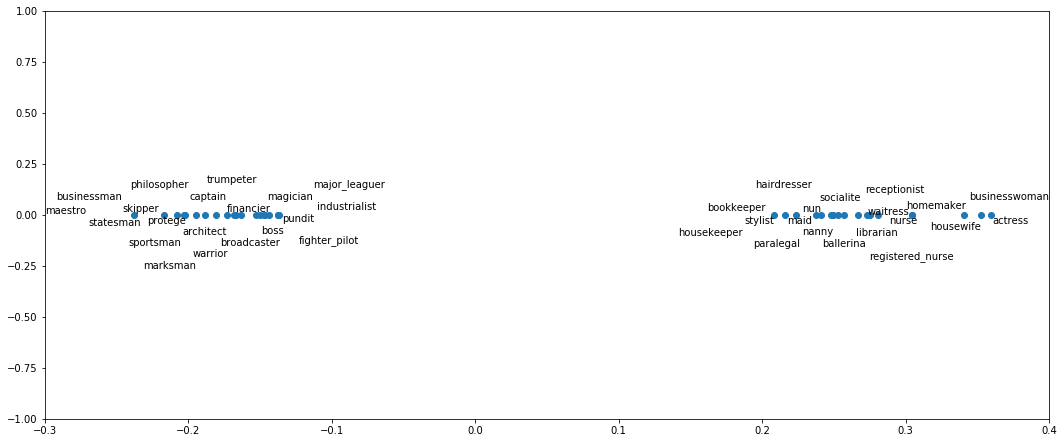

<Figure size 432x288 with 0 Axes>

In [11]:
points = []
names = []

print("Top male: ")
for i in range(0,20):
    points.append(sorted_he_she[i][0])
    names.append(sorted_he_she[i][1])
    print("she-he: {} | 10-pair: {}".format(sorted_he_she[i], sorted_10pair[i]))
print("\nTop female: ")
for i in reversed(range(1, 20)):
    points.append(sorted_he_she[-i][0])
    names.append(sorted_he_she[-i][1])
    print("she-he: {} | 10-pair: {}".format(sorted_he_she[-i], sorted_10pair[-i]))
    
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

print(points)
print(names)
y = np.zeros(len(points))




fig, ax = plt.subplots()
fig.set_size_inches(18, 7.5)
ax.set_xlim([-.3,.4])
ax.set_ylim([-1,1])
ax.plot(points, y, 'o')



texts = []
for x, y, s in zip(points, y, names):
    texts.append(plt.text(x, y, s))

adjust_text(texts)
plt.show()
plt.savefig("gender_bias_profession.png")

### Analogies
she is to x as he is to y

In [12]:
a_gender_ = em.best_analogies_dist_thresh(gender_)
a_gender = em.best_analogies_dist_thresh(gender)
basic_a = {a:b for (a,b,c) in a_gender_}
pca_a = {a:b for (a,b,c) in a_gender}

Computing neighbors
Mean: 10.219732808538016
Median: 7.0


In [13]:
print("Analogies: she -> he_1 | he_2")
print("word -> she-he analogy | PCA analogy\n")
for w in basic_a.keys():
    try:
        print("{} -> {} | {}".format(w, basic_a[w], pca_a[w]))
    except KeyError:
        pass

Analogies: she -> he_1 | he_2
word -> she-he analogy | PCA analogy

she -> he | he
herself -> himself | himself
her -> his | his
woman -> man | man
daughter -> son | son
businesswoman -> businessman | businessman
girl -> boy | boy
actress -> actor | actor
chairwoman -> chairman | chairman
heroine -> hero | hero
mother -> father | father
spokeswoman -> spokesman | spokesman
sister -> brother | brother
girls -> boys | boys
sisters -> brothers | brothers
queen -> king | king
niece -> nephew | nephew
councilwoman -> councilman | councilman
motherhood -> fatherhood | fatherhood
women -> men | men
petite -> lanky | lanky
ovarian_cancer -> prostate_cancer | prostate_cancer
Anne -> John | John
schoolgirl -> schoolboy | schoolboy
granddaughter -> grandson | grandson
aunt -> uncle | uncle
matriarch -> patriarch | patriarch
twin_sister -> twin_brother | twin_brother
mom -> dad | dad
lesbian -> gay | gay
husband -> younger_brother | younger_brother
gal -> dude | dude
lady -> gentleman | gentleman


Simple Visualization

In [12]:
we.viz(a_gender)

   0                      herself | himself                      0.94
   1                          she | he                           0.94
   2                          her | his                          0.91
   3                        woman | man                          0.82
   4                     daughter | son                          0.74
   5                         girl | boy                          0.74
   6                      actress | actor                        0.72
   7                businesswoman | businessman                  0.70
   8                       sister | brother                      0.69
   9                       mother | father                       0.69
  10                  spokeswoman | spokesman                    0.67
  11                      heroine | hero                         0.67
  12                   chairwoman | chairman                     0.67
  13                      sisters | brothers                     0.67
  14                

### Debiasing
Let's debias the embeddings and measure bias again

In [14]:
import json
# dwe.debias
with open('debiaswe/data/definitional_pairs.json', "r") as f:
    defs = json.load(f)

with open('debiaswe/data/equalize_pairs.json', "r") as f:
    equalize_pairs = json.load(f)
    
with open('debiaswe/data/gender_specific_seed.json', "r") as f:
    gender_specific_words = json.load(f)

print("definitional", defs)
print("\ngender specific", len(gender_specific_words), gender_specific_words[:10])

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]

gender specific 218 ['actress', 'actresses', 'aunt', 'aunts', 'bachelor', 'ballerina', 'barbershop', 'baritone', 'beard', 'beards']


In [15]:
# import errors, sourced from debiaswe/debiaswe/debias

def debias(embedding, gender_specific_words, definitional, equalize):
    E = embedding
    gender_direction = we.doPCA(definitional, E).components_[0]
    specific_set = set(gender_specific_words)
    for i, w in enumerate(E.words):
        if w not in specific_set:
            E.vecs[i] = we.drop(E.vecs[i], gender_direction)
    E.normalize()
    candidates = {x for e1, e2 in equalize for x in [(e1.lower(), e2.lower()),
                                                     (e1.title(), e2.title()),
                                                     (e1.upper(), e2.upper())]}
    print(candidates)
    for (a, b) in candidates:
        if (a in E.index and b in E.index):
            y = we.drop((E.v(a) + E.v(b)) / 2, gender_direction)
            z = np.sqrt(1 - np.linalg.norm(y)**2)
            if (E.v(a) - E.v(b)).dot(gender_direction) < 0:
                z = -z
            E.vecs[E.index[a]] = z * gender_direction + y
            E.vecs[E.index[b]] = -z * gender_direction + y
    E.normalize()
    return E

In [16]:
em_d = debias(em, gender_specific_words, defs, equalize_pairs)

26423 26423 26423
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
{('congressman', 'congresswoman'), ('Monastery', 'Convent'), ('Boys', 'Girls'), ('men', 'women'), ('COUNCILMAN', 'COUNCILWOMAN'), ('Wives', 'Husbands'), ('fella', 'granny'), ('Himself', 'Herself'), ('WIVES', 'HUSBANDS'), ('grandpa', 'grandma'), ('kings', 'queens'), ('DAD', 'MOM'), ('KING', 'QUEEN'), ('Nephew', 'Niece'), ('Ex_Girlfriend', 'Ex_Boyfriend'), ('Chairman', 'Chairwoman'), ('colt', 'filly'), ('schoolboy', 'schoolgirl'), ('Schoolboy', 'Schoolgirl'), ('FRATERNITY', 'SORORITY'), ('BROTHER', 'SISTER'), ('gentlemen', 'ladies'), ('sons', 'daughters'), ('Dad', 'Mom'), ('He', 'She'), ('NEPHEW', 'NIECE'), ('his', 'her'), ('Prince', 'Princess'), ('Catholic_Priest', 'Nun'), ('EX_GIRLFRIEND', 'EX_BOYFRIEND'), ('fathers', 'mothers'), ('KINGS', 'QUEENS'), ('PROSTATE_CANCER', 'OVARIAN_CANCER'), ('SCHOOLBOY', 'SCHOOLGIRL'), ('CONGRESSMAN', 'CONGRESSWOMAN'), ('Father', 'Mother'), ('himself', 'he

Top male: 
she-he: (-0.41963252, 'congressman') | 10-pair: (-0.43325213, 'businessman')
she-he: (-0.4067585, 'businessman') | 10-pair: (-0.42799938, 'congressman')
she-he: (-0.32398787, 'councilman') | 10-pair: (-0.3652526, 'dad')
she-he: (-0.30967075, 'dad') | 10-pair: (-0.35791728, 'councilman')
she-he: (-0.21665451, 'statesman') | 10-pair: (-0.22225758, 'statesman')
she-he: (-0.11345412, 'salesman') | 10-pair: (-0.15711336, 'salesman')
she-he: (-0.073004864, 'monk') | 10-pair: (-0.106753625, 'handyman')
she-he: (-0.072163954, 'handyman') | 10-pair: (-0.08172004, 'monk')
she-he: (-0.049468238, 'minister') | 10-pair: (-6.9052476e-08, 'alter_ego')
she-he: (-0.043583848, 'archbishop') | 10-pair: (-5.5522833e-08, 'stylist')
she-he: (-0.040207215, 'bishop') | 10-pair: (-5.3853e-08, 'senator')
she-he: (-0.038332447, 'commissioner') | 10-pair: (-5.0262315e-08, 'socialite')
she-he: (-0.035724364, 'surgeon') | 10-pair: (-4.82396e-08, 'politician')
she-he: (-0.033134002, 'trader') | 10-pair: (

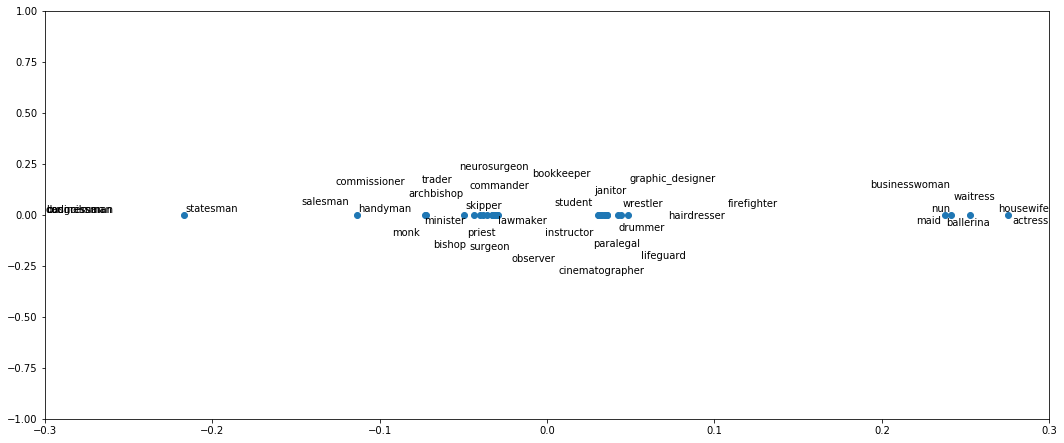

<Figure size 432x288 with 0 Axes>

In [17]:
debiased_profs_ = sorted([(em_d.v(w).dot(gender_), w) for w in profession_words])
debiased_profs = sorted([(em_d.v(w).dot(gender), w) for w in profession_words])

names = []
points = []
print("Top male: ")
for i in range(0,20):
    points.append(debiased_profs_[i][0])
    names.append(debiased_profs_[i][1])
    print("she-he: {} | 10-pair: {}".format(debiased_profs_[i], debiased_profs[i]))
print("\nTop female: ")
for i in reversed(range(1, 20)):
    points.append(debiased_profs_[-i][0])
    names.append(debiased_profs_[-i][1])
    print("she-he: {} | 10-pair: {}".format(debiased_profs_[-i], debiased_profs[-i]))
    
    
    
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

print(points)
print(names)
y = np.zeros(len(points))




fig, ax = plt.subplots()
fig.set_size_inches(18, 7.5)
ax.set_xlim([-.3,.3])
ax.set_ylim([-1,1])
ax.plot(points, y, 'o')


texts = []
for x, y, s in zip(points, y, names):
    texts.append(plt.text(x, y, s))

adjust_text(texts)
plt.show()
plt.savefig("gender_debias_profession.png")

In [17]:
debiased_a_ = em_d.best_analogies_dist_thresh(gender_)
debiased_a = em_d.best_analogies_dist_thresh(gender)
basic_a_d = {a:b for (a,b,c) in debiased_a_}
pca_a_d = {a:b for (a,b,c) in debiased_a}

print("Analogies: she -> he_1 | he_2")
print("word -> she-he analogy | PCA analogy\n")
for w in basic_a.keys():
    try:
        print("{} -> {} | {}".format(w, basic_a_d[w], pca_a_d[w]))
    except KeyError:
        pass

Computing neighbors
Mean: 10.2185974341
Median: 7.0
Analogies: she -> he_1 | he_2
word -> she-he analogy | PCA analogy

she -> he | he
herself -> himself | himself
her -> his | his
woman -> man | man
daughter -> son | son
businesswoman -> businessman | businessman
girl -> boy | boy
actress -> actor | actor
chairwoman -> chairman | chairman
heroine -> protagonist | protagonist
mother -> father | father
spokeswoman -> spokesman | spokesman
sister -> brother | brother
girls -> boys | boys
sisters -> brothers | brothers
queen -> king | king
niece -> nephew | nephew
councilwoman -> councilman | councilman
motherhood -> fatherhood | fatherhood
women -> men | men
ovarian_cancer -> prostate_cancer | prostate_cancer
schoolgirl -> schoolboy | schoolboy
granddaughter -> grandson | grandson
aunt -> uncle | uncle
matriarch -> patriarch | patriarch
twin_sister -> twin_brother | twin_brother
mom -> dad | dad
lesbian -> gay | gay
husband -> younger_brother | younger_brother
gal -> dude | dude
lady -> 

Another simple visualization

In [18]:
we.viz(debiased_a)

   0                        niece | nephew                       1.0
   1                         mare | gelding                      1.0
   2                         moms | dads                         1.0
   3                granddaughter | grandson                     1.0
   4                 councilwoman | councilman                   1.0
   5               granddaughters | grandsons                    1.0
   6                         gals | dudes                        1.0
   7                   motherhood | fatherhood                   1.0
   8                      mothers | fathers                      1.0
   9                          her | his                          1.0
  10                      herself | himself                      1.0
  11                        girls | boys                         1.0
  12                    daughters | sons                         1.0
  13                      convent | monastery                    1.0
  14                 ex_boyfriend 